# 7.1 MLP on Adult Income data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from Dataset import Dataset

# Model training

In [2]:
df1 = pd.read_csv('data/adult.data', header=None)
df2 = pd.read_csv('data/adult.test', header=None)
df = pd.concat([df1, df2])

In [3]:
df.columns = ['Age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
             'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
             'hours-per-week', 'native-country', 'over-50k']

In [4]:
df['over-50k'] = df['over-50k'].apply(lambda x: x.replace('.',''))

In [5]:
df = df.drop(['native-country'], axis=1)

In [6]:
df = pd.get_dummies(df, drop_first=True)

In [7]:
df.rename(columns={"over-50k_ >50K": "over_50k"}, inplace=True)

In [8]:
train = df[:len(df1)]
test = df[len(df1):]

In [9]:
X_train, y_train = train.drop('over_50k', axis=1), train['over_50k']
X_test, y_test = test.drop('over_50k', axis=1), test['over_50k']

In [10]:
mlp = MLPClassifier(hidden_layer_sizes=(100,75), random_state=0)

In [11]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 75), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [12]:
mlp.score(X_test, y_test)

0.814446287083103

In [13]:
probs = mlp.predict_proba(X_test)

In [14]:
df_test = pd.DataFrame(X_test)
df_test['actual'] = y_test

In [15]:
df_test[['prob_0','prob_1']] = probs

In [16]:
df_test['pred'] = df_test['prob_1'].apply(lambda x: 0 if x<0.5 else 1)

# Calibration analysis

In [17]:
df = pd.read_csv('data/adult_out.csv', index_col=0)
df = Dataset(df, cal_size=2500)
var='Age'

In [18]:
df.augmented_z_calibrate(var=var, label="_betaz2", degree=2)

In [19]:
splits = df.get_splits(var, max_depth=3, min_samples_leaf=int(len(df.df_cal)/10))

In [20]:
df.split_calibrate(var, splits)

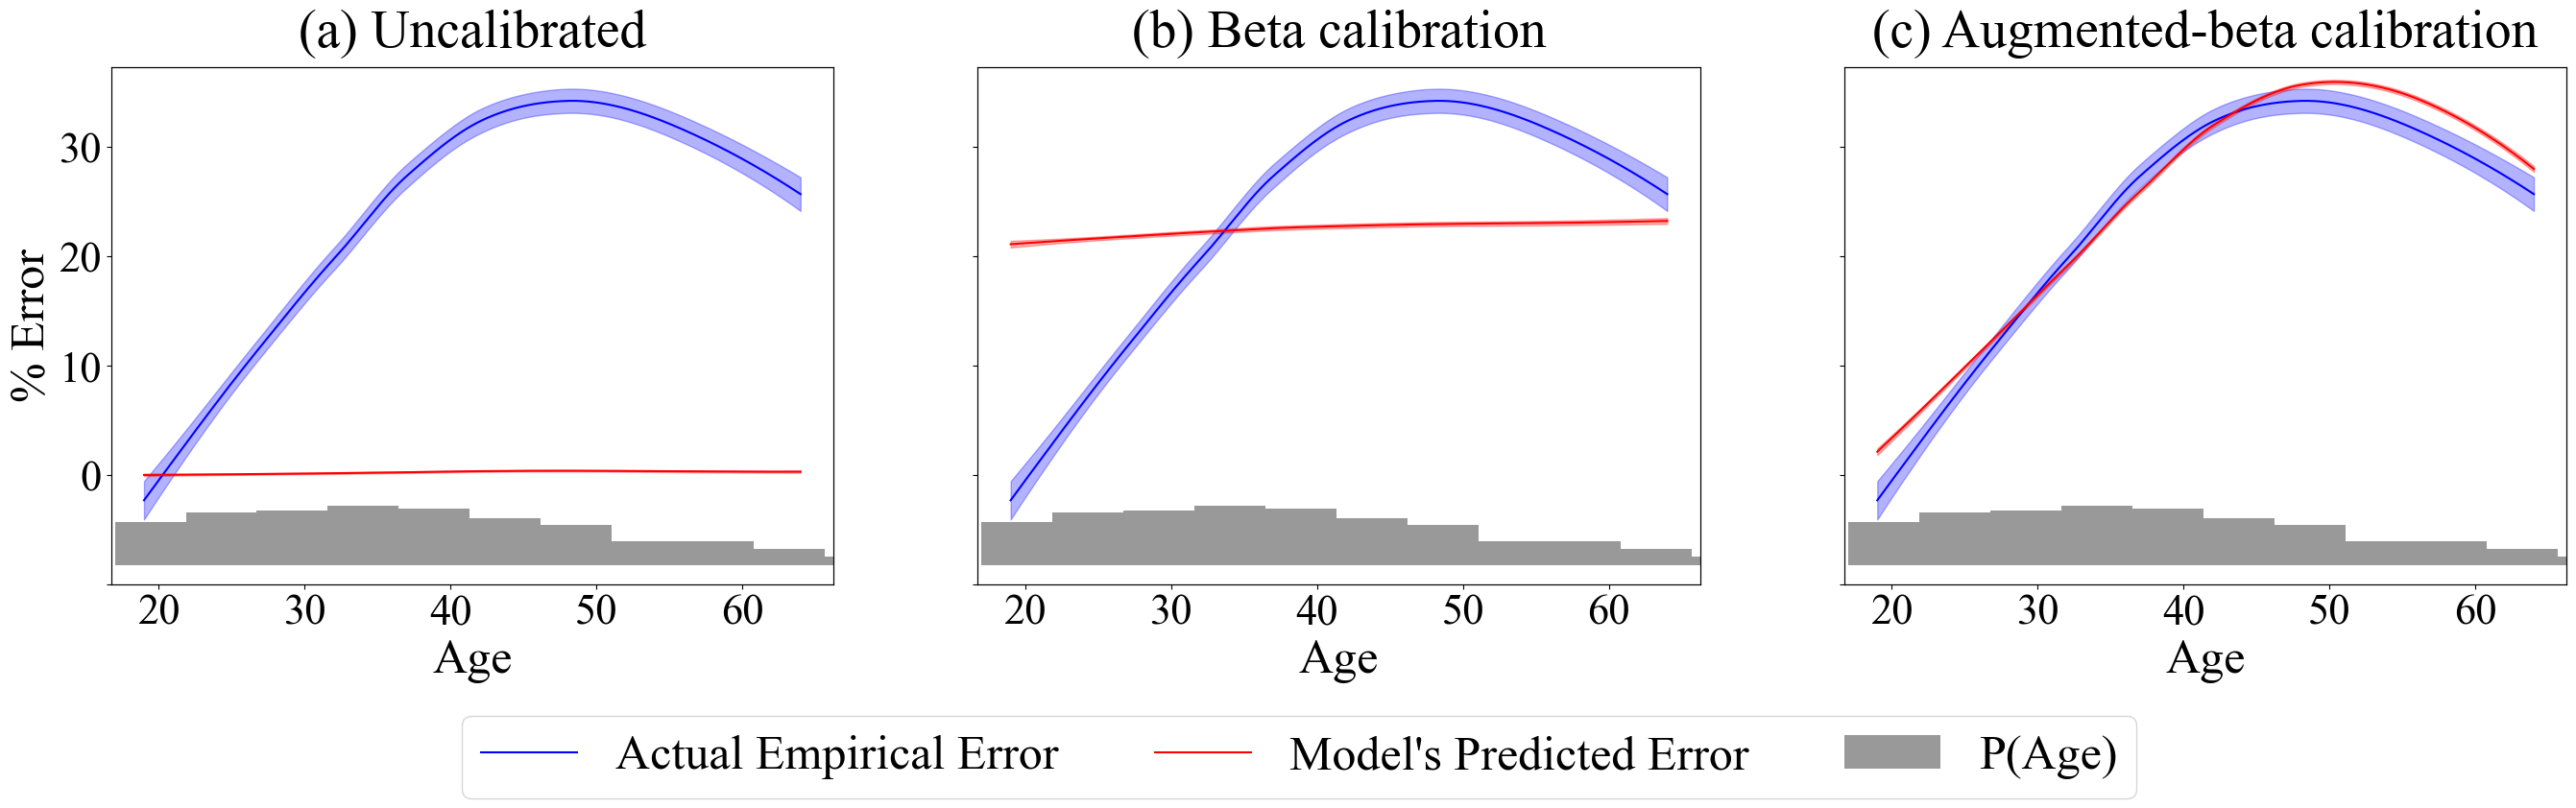

In [21]:
df.plot_compare(var=var, d2=-10, label3="_betaz2", title3="Augmented-beta calibration", filename='figs/adult_comparison2.png')

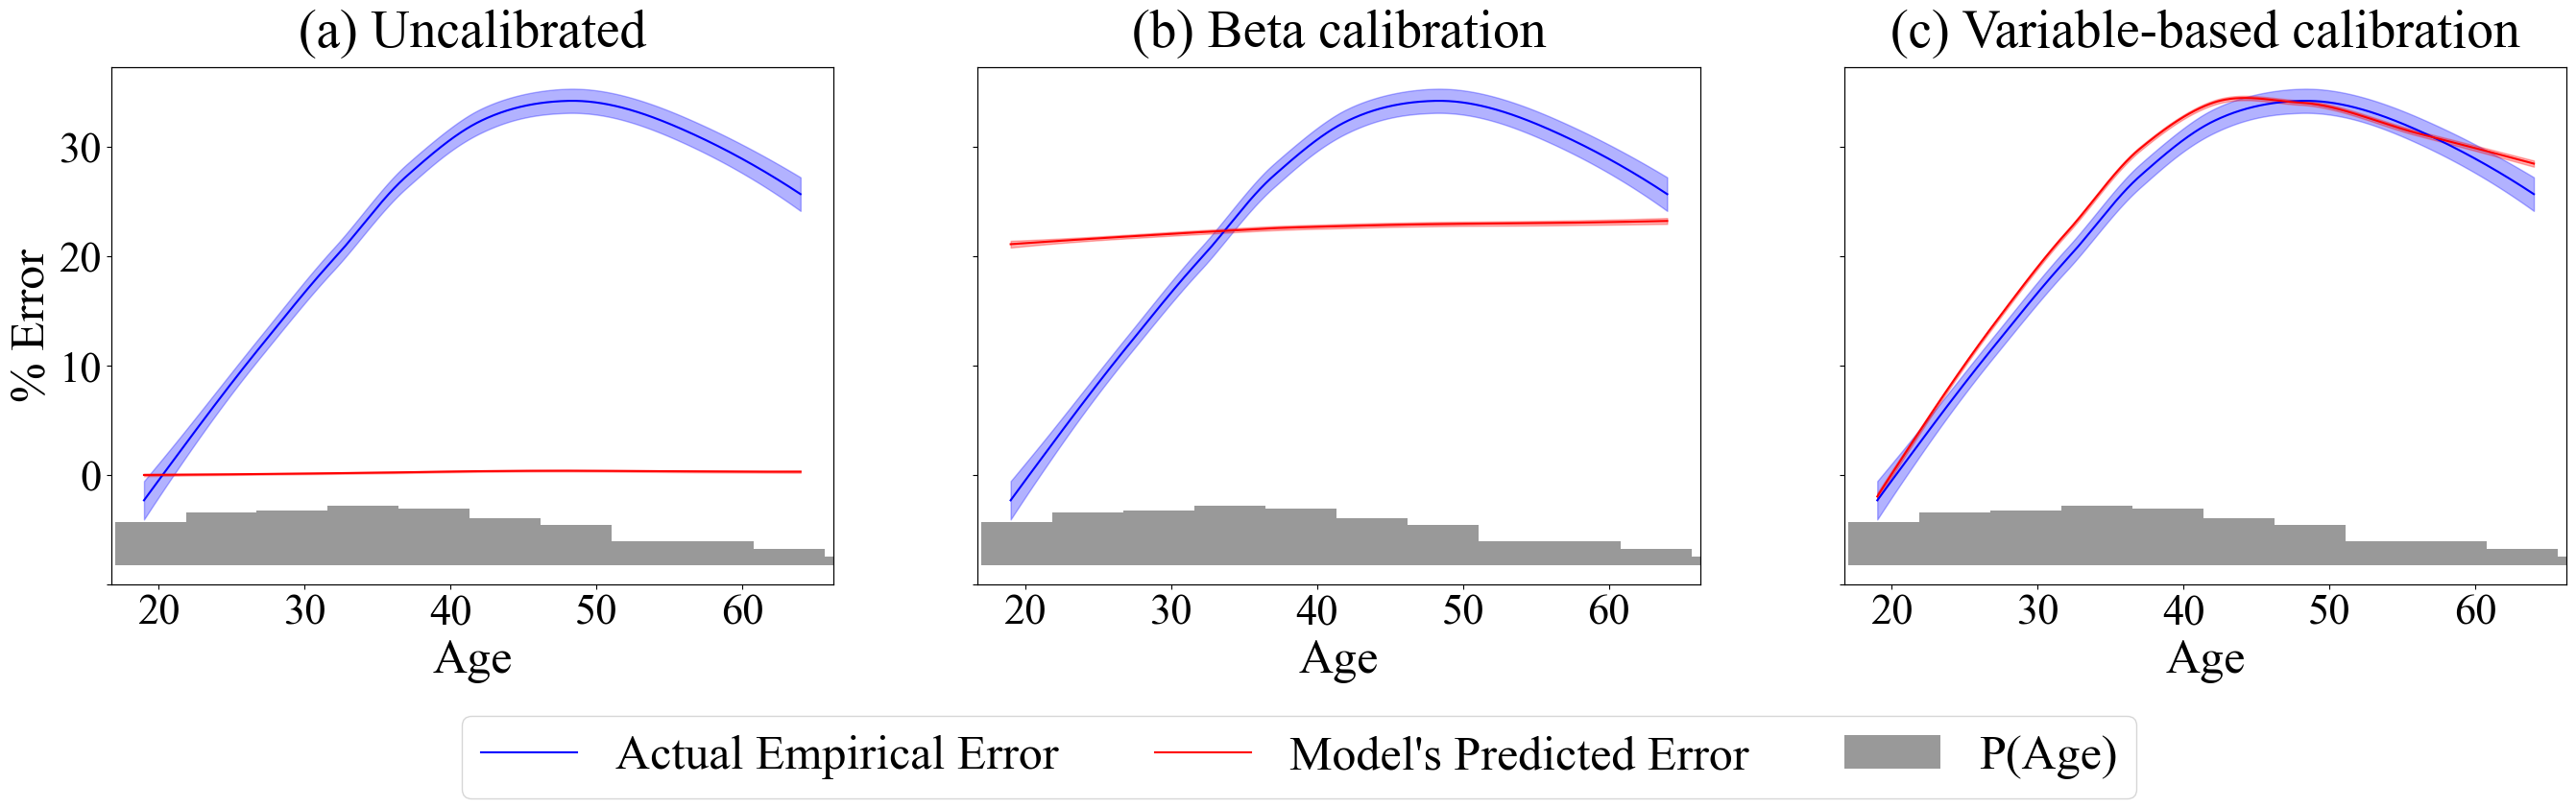

In [22]:
df.plot_compare(var=var, d2=-10, filename='figs/adult_comparison.png')

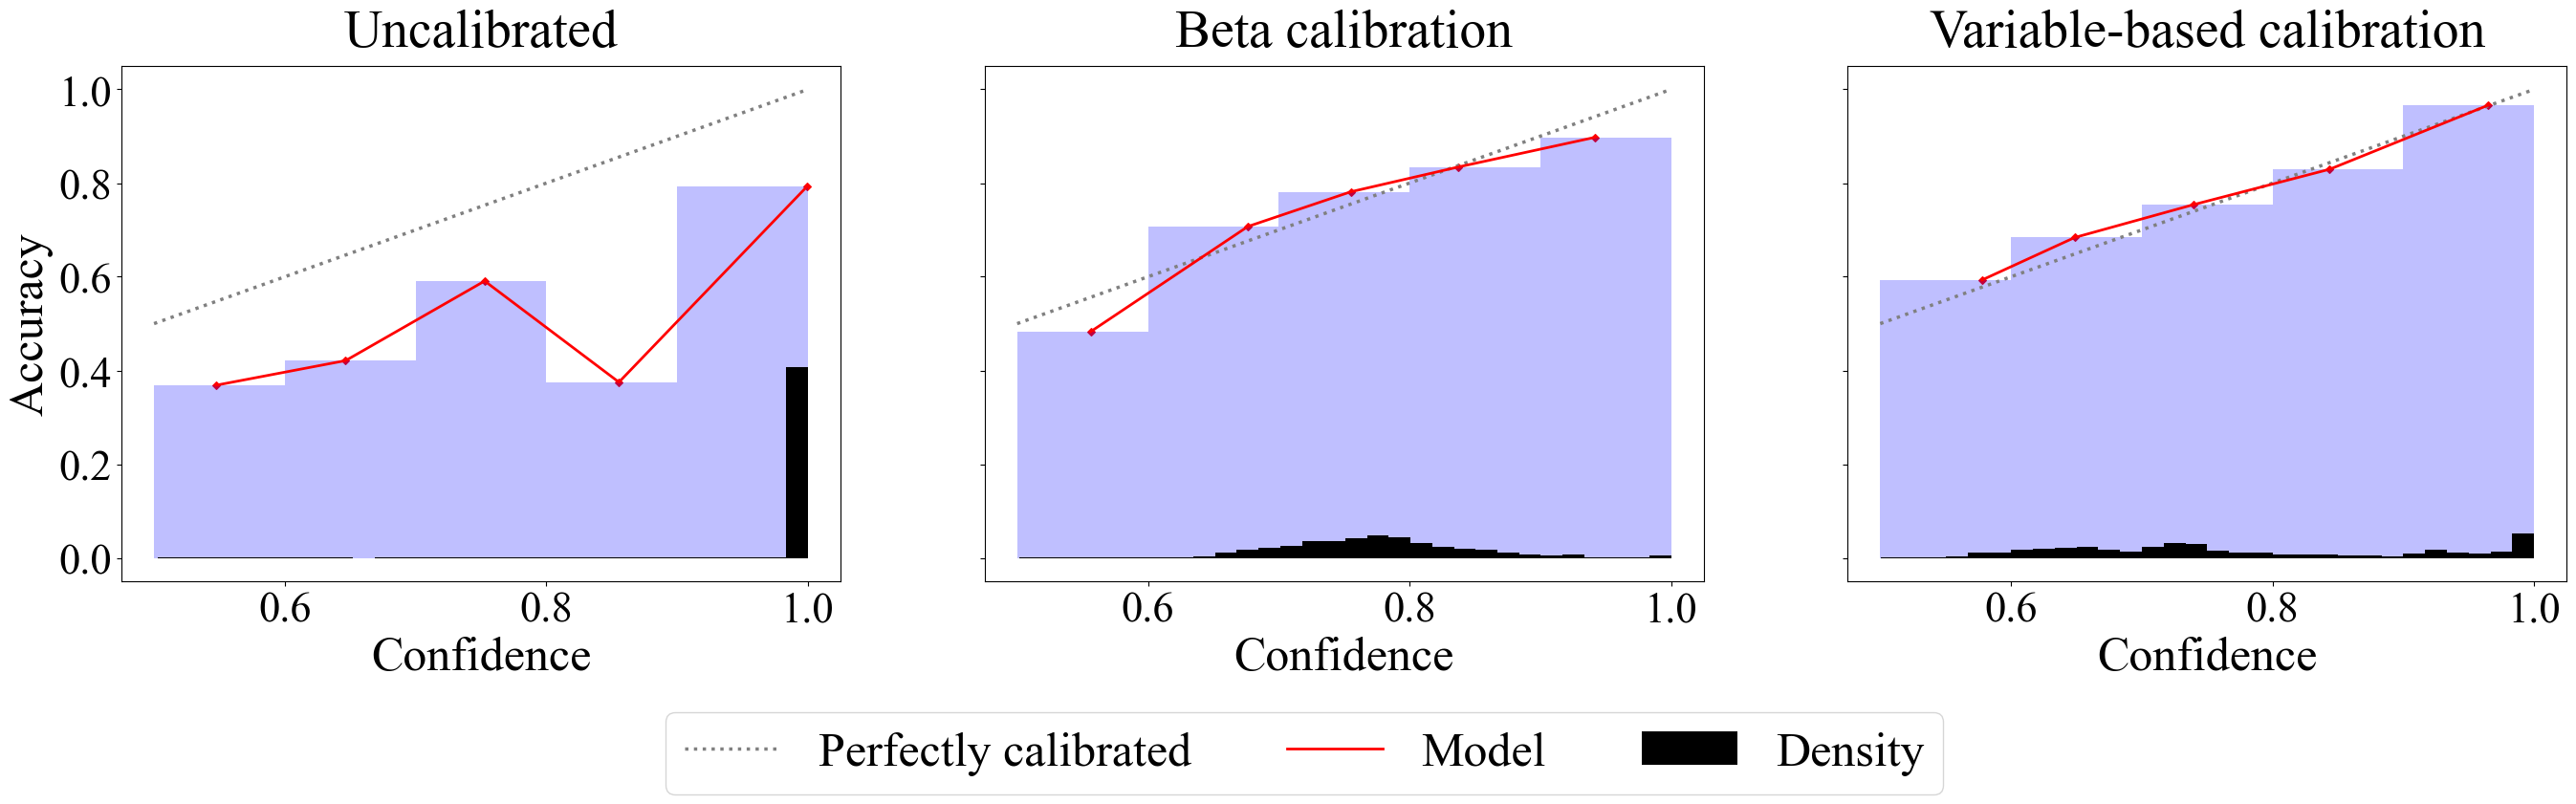

In [23]:
df.rd_compare(hist_weight=0.00003, filename="figs/adult_reliability.png")

In [24]:
for col in ['age', 'fnlwgt', 'education-num','hours-per-week']:
    print(col)
    print(df.compute_VECE(col, label="_beta"))
    print(df.max_diff(col, s=0.9, label="_beta"))

age
0.09593200720465153
23.43743833473544
fnlwgt
0.05058413975649334
12.080859520823775
education-num
0.09952789922726027
20.127375819966943
hours-per-week
0.0793501646343642
18.20506955555697


In [25]:
bins=10

In [26]:
print('uncalibrated accuracy=',df.compute_accuracy())
print("Beta calibrated accuracy=",df.compute_accuracy(label="_beta"))
print("Variable-wise calibrated accuracy=",df.compute_accuracy(label="_split"))

uncalibrated accuracy= 0.7910891807561135
Beta calibrated accuracy= 0.7908714897322401
Variable-wise calibrated accuracy= 0.791016617081489


In [27]:
print("uncalibrated ECE=",df.compute_ECE(num_bins=bins))
print("Kumar calibrated ECE=",df.compute_ECE(label="_kumar", num_bins=bins))
print("Logistic calibrated ECE=", df.compute_ECE(label="_log", num_bins=bins))
print("Beta calibrated ECE=", df.compute_ECE(label="_beta", num_bins=bins))
print("Variable-wise calibrated ECE=",df.compute_ECE(label="_split", num_bins=bins))
print("Beta-z2 calibrated ECE=",df.compute_ECE(label="_betaz2", num_bins=bins))

uncalibrated ECE= 0.20665741864533652
Kumar calibrated ECE= 0.02268951896628304
Logistic calibrated ECE= 0.045727664518174393
Beta calibrated ECE= 0.01646054558348676
Variable-wise calibrated ECE= 0.01643069123546091
Beta-z2 calibrated ECE= 0.01486738400318536


In [28]:
print("uncalibrated VECE =",df.compute_VECE(var=var, num_bins=bins))
print("Kumar calibrated VECE =",df.compute_VECE(label="_kumar",var=var, num_bins=bins))
print("Logistic calibrated VECE =",df.compute_VECE(label="_log",var=var, num_bins=bins))
print("Beta calibrated VECE =",df.compute_VECE(label="_beta",var=var, num_bins=bins))
print("Variable-wise calibrated VECE =",df.compute_VECE(label="_split",var=var, num_bins=bins))
print("Beta-z2 calibrated VECE=",df.compute_VECE(label="_betaz2",var=var, num_bins=bins))

uncalibrated VECE = 0.20665741864533657
Kumar calibrated VECE = 0.09247530358355228
Logistic calibrated VECE = 0.1012856867529069
Beta calibrated VECE = 0.09593200720465153
Variable-wise calibrated VECE = 0.021069835256998477
Beta-z2 calibrated VECE= 0.018749645710742308


In [29]:
for col in ['age', 'fnlwgt', 'education-num','hours-per-week', 'capital-gain','capital-loss']:
    print(col)
    print("uncalibrated", df.compute_VECE(col))
    print("beta", df.compute_VECE(col, label="_beta"))
    print("variable-wise", df.compute_VECE(col, label="_split"))
    print()

age
uncalibrated 0.20665741864533657
beta 0.09593200720465153
variable-wise 0.021069835256998477

fnlwgt
uncalibrated 0.20665741864533652
beta 0.05058413975649334
variable-wise 0.04102682158879836

education-num
uncalibrated 0.20665741864533654
beta 0.09952789922726027
variable-wise 0.08528493540380065

hours-per-week
uncalibrated 0.20665741864533654
beta 0.0793501646343642
variable-wise 0.06024101958097432

capital-gain
uncalibrated 0.20665741864533654
beta 0.01497347920801001
variable-wise 0.013856887414017277

capital-loss
uncalibrated 0.20665741864533654
beta 0.01497347920801001
variable-wise 0.013856887414017277

